# Lambda School Data Science Module 142
## Sampling, Confidence Intervals, and Hypothesis Testing

## Prepare - examine other available hypothesis tests

If you had to pick a single hypothesis test in your toolbox, t-test would probably be the best choice - but the good news is you don't have to pick just one! Here's some of the others to be aware of:

In [1]:
import numpy as np
from scipy.stats import chisquare  # One-way chi square test

# Chi square can take any crosstab/table and test the independence of rows/cols
# The null hypothesis is that the rows/cols are independent -> low chi square
# The alternative is that there is a dependence -> high chi square
# Be aware! Chi square does *not* tell you direction/causation

ind_obs = np.array([[1, 1], [2, 2]]).T
print(ind_obs)
print(chisquare(ind_obs, axis=None))

dep_obs = np.array([[16, 18, 16, 14, 12, 12], [32, 24, 16, 28, 20, 24]]).T
print(dep_obs)
print(chisquare(dep_obs, axis=None))

[[1 2]
 [1 2]]
Power_divergenceResult(statistic=0.6666666666666666, pvalue=0.8810148425137847)
[[16 32]
 [18 24]
 [16 16]
 [14 28]
 [12 20]
 [12 24]]
Power_divergenceResult(statistic=23.31034482758621, pvalue=0.015975692534127565)


In [2]:
# Distribution tests:
# We often assume that something is normal, but it can be important to *check*

# For example, later on with predictive modeling, a typical assumption is that
# residuals (prediction errors) are normal - checking is a good diagnostic

from scipy.stats import normaltest
# Poisson models arrival times and is related to the binomial (coinflip)
sample = np.random.poisson(5, 1000)
#Null hypothesis- sample is normally distributed
print(normaltest(sample))  # Pretty clearly not normal

NormaltestResult(statistic=42.286420848790776, pvalue=6.570832294642501e-10)


In [3]:
# Kruskal-Wallis H-test - compare the median rank between 2+ groups
# Can be applied to ranking decisions/outcomes/recommendations
# The underlying math comes from chi-square distribution, and is best for n>5
from scipy.stats import kruskal

x1 = [1, 3, 5, 7, 9]
y1 = [2, 4, 6, 8, 10]
print(kruskal(x1, y1))  # x1 is a little better, but not "significantly" so

x2 = [1, 1, 1]
y2 = [2, 2, 2]
z = [2, 2]  # Hey, a third group, and of different size!
print(kruskal(x2, y2, z))  # x clearly dominates

KruskalResult(statistic=0.2727272727272734, pvalue=0.6015081344405895)
KruskalResult(statistic=7.0, pvalue=0.0301973834223185)


And there's many more! `scipy.stats` is fairly comprehensive, though there are even more available if you delve into the extended world of statistics packages. As tests get increasingly obscure and specialized, the importance of knowing them by heart becomes small - but being able to look them up and figure them out when they *are* relevant is still important.

## T-test Assumptions

<https://statistics.laerd.com/statistical-guides/independent-t-test-statistical-guide.php>

- Independence of means

Are the means of our voting data independent (do not affect the outcome of one another)?
  
The best way to increase thel likelihood of our means being independent is to randomly sample (which we did not do).


In [0]:
from scipy.stats import ttest_ind
?ttest_ind

- "Homogeneity" of Variance? 

Is the magnitude of the variance between the two roughly the same?

I think we're OK on this one for the voting data, although it probably could be better, one party was larger than the other.

If we suspect this to be a problem then we can use Welch's T-test

In [0]:
?ttest_ind

- "Dependent Variable" (sample means) are Distributed Normally

<https://stats.stackexchange.com/questions/9573/t-test-for-non-normal-when-n50>

Lots of statistical tests depend on normal distributions. We can test for normality using Scipy as was shown above.

This assumption is often assumed even if the assumption is a weak one. If you strongly suspect that things are not normally distributed, you can transform your data to get it looking more normal and then run your test. This problem typically goes away for large sample sizes (yay Central Limit Theorem) and is often why you don't hear it brought up. People declare the assumption to be satisfied either way. 



## Central Limit Theorem



In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
sample_means = []
#3000 sample of each 30trial
# minimum 30 size for normal distribution
# number in each trial matter
N= 3000
for x in range(0,N):
  coinflips = np.random.binomial(n=1, p=.5, size=30) # fliping coin 30 times and saving into coinflips array
  one_sample = coinflips
  sample_means.append(coinflips.mean())

print(len(sample_means))
print(sample_means)

3000
[0.5333333333333333, 0.5, 0.5, 0.4666666666666667, 0.5666666666666667, 0.4, 0.5333333333333333, 0.6, 0.36666666666666664, 0.36666666666666664, 0.5, 0.4, 0.4666666666666667, 0.5666666666666667, 0.5333333333333333, 0.4666666666666667, 0.6, 0.5333333333333333, 0.6333333333333333, 0.4666666666666667, 0.5333333333333333, 0.5666666666666667, 0.6, 0.4666666666666667, 0.6, 0.5, 0.5, 0.3333333333333333, 0.5666666666666667, 0.5333333333333333, 0.5666666666666667, 0.43333333333333335, 0.5333333333333333, 0.3, 0.5666666666666667, 0.3, 0.5666666666666667, 0.36666666666666664, 0.5333333333333333, 0.5333333333333333, 0.6, 0.4, 0.5333333333333333, 0.43333333333333335, 0.4666666666666667, 0.3333333333333333, 0.4, 0.5666666666666667, 0.6, 0.4, 0.43333333333333335, 0.5, 0.6666666666666666, 0.4666666666666667, 0.5333333333333333, 0.43333333333333335, 0.5666666666666667, 0.5, 0.6333333333333333, 0.3333333333333333, 0.7, 0.5333333333333333, 0.3, 0.43333333333333335, 0.5333333333333333, 0.53333333333333

In [7]:
#to create pd histogram
df = pd.DataFrame({'a': one_sample})
df.head()

,a
0,1
1,1
2,1
3,0
4,0


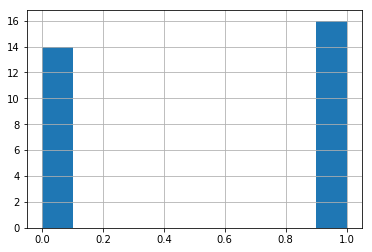

In [8]:
df.a.hist() # binomial distribution

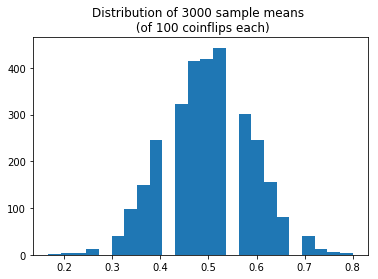

In [9]:
# distribution of the sample mean
plt.hist(sample_means, bins=24)
#ax = plt.hist(sample_means)
plt.title(f'Distribution of {N} sample means \n (of 100 coinflips each)');



What does the Central Limit Theorem State? That no matter the initial distribution of the population, the distribution of sample means taken will approximate a normal distribution as $n \rightarrow \infty$.

This has very important implications for hypothesis testing and is precisely the reason why the t-distribution begins to approximate the normal distribution as our sample size increases. 

## Standard Error of the Mean

What does it mean to "estimate"? the Population mean?

In [10]:
import numpy as np
import pandas as pd

#  uniform distribution of Average Height
mu = 70 # 4
sigma = 3 #6.5

#lambda_heights = np.random.uniform(mu, sigma, 2000) # 1 sample of 2000 size
lambda_heights = np.random.normal(mu, sigma, 2000)

print(len(lambda_heights))
lambda_heights

2000


array([66.3382549 , 71.12048032, 68.70439113, ..., 72.29965798,
       74.10482754, 67.38692924])

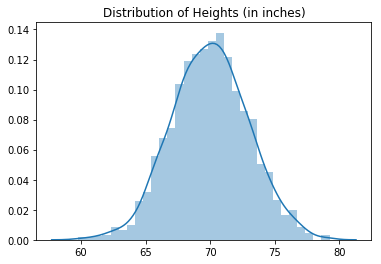

In [11]:
import seaborn as sns

sns.distplot(lambda_heights)
plt.title('Distribution of Heights (in inches)');

In [12]:
print("Population Mean:", lambda_heights.mean())
print("Population Standard Deviation:", lambda_heights.std())

Population Mean: 69.98772984095424
Population Standard Deviation: 2.9553417136473374


In [13]:
# converted into dataframe to calculate sample from sample mean
population = pd.DataFrame({'heights': lambda_heights})
print(population.shape)
population.head()

(2000, 1)


,heights
0,66.338255
1,71.120480
2,68.704391
3,71.315065
4,66.184065


In [14]:
# Take one random from population sample of size 100 and print sample mean
sample1 = population.sample(100)
print(sample1.shape)
sample1.head()

(100, 1)


,heights
1337,65.336049
1741,68.822484
135,67.529181
278,68.218583
799,69.867888


In [15]:
print('Sample Mean #1:', sample1.mean())

Sample Mean #1: heights    69.962191
dtype: float64


In [16]:
# Take a different random sample and print sample mean
sample2 = population.sample(100)
print(sample2.shape)
sample2.head()

(100, 1)


,heights
283,67.320253
1498,70.335359
1600,70.418444
257,72.627768
1033,70.103250


In [17]:
from scipy.stats import ttest_ind, ttest_ind_from_stats, ttest_rel
print('Sample Mean #2:', sample2['heights'].mean())


Sample Mean #2: 69.97769315648304


In [18]:
tstat, pvalue= ttest_ind(sample1, sample2)
print(tstat, pvalue)

[-0.03367484] [0.97317037]


## Build and Interpret a Confidence Interval

<img src="https://github.com/ryanallredblog/ryanallredblog.github.io/blob/master/img/Confidence_Interval.png?raw=true" width=400>

In [19]:
# generate
coinflips_10000 = np.random.binomial(n=1, p=0.5, size=10000)

sample_std = np.std(coinflips_10000)
print('Sample St Dev:', sample_std)
sample_size = len(coinflips_10000)
print('Sample Size:', sample_size)

Sample St Dev: 0.4999947099720155
Sample Size: 10000


In [20]:
# calculation of standard error
standard_error= sample_std/sample_size**(0.5)
standard_error = sample_std/np.sqrt(sample_size)
print(standard_error)

0.004999947099720155


##What confidence level do we want our confidence interval to represent?¶ 
95% confidence Interval? 99% confidence interval?

In [21]:
# to calculate t-statistic
import scipy.stats as stats
help(stats.t.ppf)

Help on method ppf in module scipy.stats._distn_infrastructure:

ppf(q, *args, **kwds) method of scipy.stats._continuous_distns.t_gen instance
    Percent point function (inverse of `cdf`) at q of the given RV.
    
    Parameters
    ----------
    q : array_like
        lower tail probability
    arg1, arg2, arg3,... : array_like
        The shape parameter(s) for the distribution (see docstring of the
        instance object for more information)
    loc : array_like, optional
        location parameter (default=0)
    scale : array_like, optional
        scale parameter (default=1)
    
    Returns
    -------
    x : array_like
        quantile corresponding to the lower tail probability q.



In [22]:
# for 95% confidence level
t = stats.t.ppf(0.975, sample_size-1) # degreebof freedom(n-1), percentage of cut off u want
t

1.9602012636213575

In [23]:
sample_mean = coinflips_10000.mean()
margin_of_error = t*standard_error
confidence_interval = (sample_mean - t*standard_error, sample_mean + t*standard_error)

print("Sample Mean: ", sample_mean)
print("Margin of Error: ", margin_of_error)
print("Confidence Interval: ", confidence_interval)


Sample Mean:  0.4977
Margin of Error:  0.00980090262291139
Confidence Interval:  (0.4878990973770886, 0.5075009026229114)


## Graphically Represent a Confidence Interval

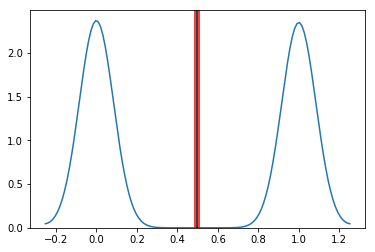

In [24]:
#confidence interval capture 95% of potential mean of the sample
import seaborn as sns

sns.kdeplot(coinflips_10000)
plt.axvline(x=sample_mean, color='k')
plt.axvline(x=confidence_interval[0], color='r')
plt.axvline(x=confidence_interval[1], color='r')

## Relationship between Confidence Intervals and T-tests

Confidence Interval == Bounds of statistical significance for our t-test

A sample mean that falls inside of our confidence interval will "FAIL TO REJECT" our null hypothesis

A sample mean that falls outside of our confidence interval will "REJECT" our null hypothesis

In [0]:
from scipy.stats import t, ttest_1samp

In [26]:
import numpy as np

coinflip_means = []
for x in range(0,100):
  coinflips = np.random.binomial(n=1, p=.5, size=30)
  coinflip_means.append(coinflips.mean())

print(coinflip_means)

[0.36666666666666664, 0.6333333333333333, 0.4, 0.5, 0.6666666666666666, 0.43333333333333335, 0.5333333333333333, 0.5666666666666667, 0.43333333333333335, 0.5, 0.36666666666666664, 0.43333333333333335, 0.5333333333333333, 0.5333333333333333, 0.7666666666666667, 0.5666666666666667, 0.43333333333333335, 0.5, 0.4, 0.5, 0.5, 0.5, 0.5333333333333333, 0.5333333333333333, 0.4666666666666667, 0.7, 0.4666666666666667, 0.4666666666666667, 0.6, 0.4666666666666667, 0.5, 0.5333333333333333, 0.6333333333333333, 0.5, 0.5333333333333333, 0.43333333333333335, 0.36666666666666664, 0.5, 0.6, 0.5, 0.5333333333333333, 0.6, 0.4666666666666667, 0.4666666666666667, 0.5, 0.4, 0.36666666666666664, 0.4666666666666667, 0.6333333333333333, 0.5333333333333333, 0.5333333333333333, 0.5, 0.5333333333333333, 0.4666666666666667, 0.5333333333333333, 0.5666666666666667, 0.4666666666666667, 0.4666666666666667, 0.5333333333333333, 0.43333333333333335, 0.5333333333333333, 0.4, 0.4666666666666667, 0.4666666666666667, 0.6666666

In [27]:
# Sample Size
n = len(coinflip_means)
# Degrees of Freedom
dof = n-1
# The Mean of Means:
mean = np.mean(coinflip_means)
# Sample Standard Deviation
sample_std = np.std(coinflip_means, ddof=1,)
# Standard Error
std_err = sample_std/n**.5

CI = t.interval(.95, dof, loc=mean, scale=std_err)
print("95% Confidence Interval: ", CI)

95% Confidence Interval:  (0.4876842085270527, 0.520982458139614)


In [0]:
#t = stats.t.ppf(0.975, n-1) # degreebof freedom(n-1), percentage of cut off u want
#t

In [29]:
'''You can roll your own CI calculation pretty easily. 
The only thing that's a little bit challenging 
is understanding the t stat lookup'''

# 95% confidence interval
t_stat = t.ppf(.975, dof)
print("t Statistic:", t_stat)

CI = (mean-(t_stat*std_err), mean+(t_stat*std_err))
print("Confidence Interval", CI)

t Statistic: 1.9842169515086827
Confidence Interval (0.4876842085270527, 0.520982458139614)


A null hypothesis that's just inside of our confidence interval == fail to reject



In [30]:
ttest_1samp(coinflip_means, .49)

Ttest_1sampResult(statistic=1.7082245044433628, pvalue=0.09072846299317185)

A null hypothesis that's just outside of our confidence interval == reject



In [31]:
ttest_1samp(coinflip_means, .4818927)

Ttest_1sampResult(statistic=2.6744399829229213, pvalue=0.008758283683203708)

In [0]:
def confidence_interval(data, confidence=0.95):
  """
  Calculate a confidence interval around a sample mean for given data.
  Using t-distribution and two-tailed test, default 95% confidence. 
  
  Arguments:
    data - iterable (list or numpy array) of sample observations
    confidence - level of confidence for the interval
  
  Returns:
    tuple of (mean, lower bound, upper bound)
  """
  data = np.array(data)
  mean = np.mean(data)
  n = len(data)
  stderr = stats.sem(data)
  interval = stderr * stats.t.ppf((1 + confidence) / 2.0, n - 1)
  return (mean, mean - interval, mean + interval)

## Run a $\chi^{2}$ Test "by hand" (Using Numpy)

In [33]:
df = pd.read_csv('https://raw.githubusercontent.com/ryanleeallred/datasets/master/adult.csv', na_values=" ?")
print(df.shape)
df.head()

(32561, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


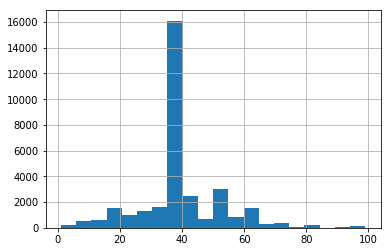

In [34]:
df['hours-per-week'].hist(bins=20);

In [35]:
df.describe(exclude='number')

,workclass,education,marital-status,occupation,relationship,race,sex,country,salary
count,30725,32561,32561,30718,32561,32561,32561,31978,32561
unique,8,16,7,14,6,5,2,41,2
top,Private,HS-grad,Married-civ-spouse,Prof-specialty,Husband,White,Male,United-States,<=50K
freq,22696,10501,14976,4140,13193,27816,21790,29170,24720


In [36]:
cut_points = [0, 9, 19, 29, 39, 49, 500]
label_names = ['0-9','10-19','20-29','30-39','40-49','50+']
df['hours_per_week_categories'] = pd.cut(df['hours-per-week'], cut_points, labels=label_names)
df.hours_per_week_categories.value_counts()

40-49    18336
50+       6462
30-39     3667
20-29     2392
10-19     1246
0-9        458
Name: hours_per_week_categories, dtype: int64

In [37]:
df.sex.value_counts()

 Male      21790
 Female    10771
Name: sex, dtype: int64

In [38]:
df = df.sort_values(by='hours_per_week_categories')
contingency_table = pd.crosstab(df['sex'], df['hours_per_week_categories'], margins=True)
contingency_table

hours_per_week_categories,0-9,10-19,20-29,30-39,40-49,50+,All
sex,,,,,,,
Female,235,671,1287,1914,5636,1028,10771
Male,223,575,1105,1753,12700,5434,21790
All,458,1246,2392,3667,18336,6462,32561


## Expected Value Calculation
\begin{align}
expected_{i,j} =\frac{(row_{i} \text{total})(column_{j} \text{total}) }{(\text{total observations})}  
\end{align}

In [39]:
row_sums = contingency_table.iloc[0:2, 6].values
col_sums = contingency_table.iloc[2, 0:6].values
#value=contingency_table.iloc[1,2]
#print(value)
print(row_sums)
print(col_sums)

[10771 21790]
[  458  1246  2392  3667 18336  6462]


In [40]:
total = contingency_table.loc['All','All']
total

32561

In [41]:
expected_row=[]
for i in range(len(row_sums)):
  expected=[]
  for j in range(len(col_sums)):
    expected_value=(row_sums[i]*col_sums[j])/total
    expected.append(expected_value)
  expected_row.append(expected)  
  
  
expected_row = np.array(expected_row)
print(expected_row.shape)
print(expected_row)  
    


(2, 6)
[[  151.50388502   412.16995793   791.26046497  1213.02346365
   6065.44811277  2137.59411566]
 [  306.49611498   833.83004207  1600.73953503  2453.97653635
  12270.55188723  4324.40588434]]


## Chi-Squared Statistic with Numpy

\begin{align}
\chi^2 = \sum \frac{(observed_{i}-expected_{i})^2}{(expected_{i})}
\end{align}

For the $observed$ values we will just use a version of our contingency table without the margins as a numpy array. In this way, if our observed values array and our expected values array are the same shape, then we can subtract them and divide them directly which makes the calculations a lot cleaner. No for loops!

In [42]:
observed = pd.crosstab(df['sex'], df['hours_per_week_categories']).values
print(observed.shape)
observed

(2, 6)


array([[  235,   671,  1287,  1914,  5636,  1028],
       [  223,   575,  1105,  1753, 12700,  5434]])

In [43]:
chi_squared = ((observed - expected)**2/(expected)).sum()
chi_squared

7085.386054301223

In [44]:
# Calculate the p-value from the chi_squared and dof
p_value = stats.chi2.sf(chi_squared, dof)
print(f"P-value: {p_value}")

P-value: 0.0


Reject the null hypothesis of being independent

## Run a $\chi^{2}$ Test using Scipy

In [45]:
help(stats.chi2_contingency)

Help on function chi2_contingency in module scipy.stats.contingency:

chi2_contingency(observed, correction=True, lambda_=None)
    Chi-square test of independence of variables in a contingency table.
    
    This function computes the chi-square statistic and p-value for the
    hypothesis test of independence of the observed frequencies in the
    contingency table [1]_ `observed`.  The expected frequencies are computed
    based on the marginal sums under the assumption of independence; see
    `scipy.stats.contingency.expected_freq`.  The number of degrees of
    freedom is (expressed using numpy functions and attributes)::
    
        dof = observed.size - sum(observed.shape) + observed.ndim - 1
    
    
    Parameters
    ----------
    observed : array_like
        The contingency table. The table contains the observed frequencies
        (i.e. number of occurrences) in each category.  In the two-dimensional
        case, the table is often described as an "R x C table".
    

In [46]:
chi_squared, p_value, dof, expected = stats.chi2_contingency(observed)
#print(chi_squared, p_value, dof, expected)
print(f"Chi-Squared: {chi_squared}")
print(f"P-value: {p_value}")
print(f"Degrees of Freedom: {dof}") 
print("Expected: \n", np.array(expected))

Chi-Squared: 2287.190943926107
P-value: 0.0
Degrees of Freedom: 5
Expected: 
 [[  151.50388502   412.16995793   791.26046497  1213.02346365
   6065.44811277  2137.59411566]
 [  306.49611498   833.83004207  1600.73953503  2453.97653635
  12270.55188723  4324.40588434]]


Null Hypothesis: Hours worked per week bins is **independent** of sex. 

Due to a p-value of 0, we REJECT the null hypothesis that hours worked per week and sex are independent, and conclude that there is an association between hours worked per week and sex. 

## Assignment - Build a confidence interval

A confidence interval refers to a neighborhood around some point estimate, the size of which is determined by the desired p-value. For instance, we might say that 52% of Americans prefer tacos to burritos, with a 95% confidence interval of +/- 5%.

52% (0.52) is the point estimate, and +/- 5% (the interval $[0.47, 0.57]$) is the confidence interval. "95% confidence" means a p-value $\leq 1 - 0.95 = 0.05$.

In this case, the confidence interval includes $0.5$ - which is the natural null hypothesis (that half of Americans prefer tacos and half burritos, thus there is no clear favorite). So in this case, we could use the confidence interval to report that we've failed to reject the null hypothesis.

But providing the full analysis with a confidence interval, including a graphical representation of it, can be a helpful and powerful way to tell your story. Done well, it is also more intuitive to a layperson than simply saying "fail to reject the null hypothesis" - it shows that in fact the data does *not* give a single clear result (the point estimate) but a whole range of possibilities.

How is a confidence interval built, and how should it be interpreted? It does *not* mean that 95% of the data lies in that interval - instead, the frequentist interpretation is "if we were to repeat this experiment 100 times, we would expect the average result to lie in this interval ~95 times."

For a 95% confidence interval and a normal(-ish) distribution, you can simply remember that +/-2 standard deviations contains 95% of the probability mass, and so the 95% confidence interval based on a given sample is centered at the mean (point estimate) and has a range of +/- 2 (or technically 1.96) standard deviations.

Different distributions/assumptions (90% confidence, 99% confidence) will require different math, but the overall process and interpretation (with a frequentist approach) will be the same.

Your assignment - using the data from the prior module ([congressional voting records](https://archive.ics.uci.edu/ml/datasets/Congressional+Voting+Records)):


### Confidence Intervals:
1. Generate and numerically represent a confidence interval
2. Graphically (with a plot) represent the confidence interval
3. Interpret the confidence interval - what does it tell you about the data and its distribution?

### Chi-squared tests:
4. Take a dataset that we have used in the past in class that has **categorical** variables. Pick two of those categorical variables and run a chi-squared tests on that data
  - By hand using Numpy
  - In a single line using Scipy

Stretch goals:

1. Write a summary of your findings, mixing prose and math/code/results. *Note* - yes, this is by definition a political topic. It is challenging but important to keep your writing voice *neutral* and stick to the facts of the data. Data science often involves considering controversial issues, so it's important to be sensitive about them (especially if you want to publish).
2. Apply the techniques you learned today to your project data or other data of your choice, and write/discuss your findings here.
3. Refactor your code so it is elegant, readable, and can be easily run for all issues.

In [47]:
# TODO - your code!
import pandas as pd
columns=['Party', 'handicapped_infants', 'water_project','adoption_budget','physician_fee','salvador_aid', 'religious_groups','satellite_test','aid_to_nicaraguan', 'mx_missile',
         'immigration', 'synfuels_cutback','education_spending','superfund_sue','crime','exports','export_south-africa']
df=pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data', names= columns, na_values='?')
print(df.shape)
df.head()

(435, 17)


,Party,handicapped_infants,water_project,adoption_budget,physician_fee,salvador_aid,religious_groups,satellite_test,aid_to_nicaraguan,mx_missile,immigration,synfuels_cutback,education_spending,superfund_sue,crime,exports,export_south-africa
0,republican,n,y,n,y,y,y,n,n,n,y,NaN,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,NaN
2,democrat,NaN,y,y,NaN,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,NaN,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,NaN,y,y,y,y


In [48]:
df = df.replace({'?':np.NaN, 'n':0, 'y':1})
print(df.shape)
df.head()

(435, 17)


,Party,handicapped_infants,water_project,adoption_budget,physician_fee,salvador_aid,religious_groups,satellite_test,aid_to_nicaraguan,mx_missile,immigration,synfuels_cutback,education_spending,superfund_sue,crime,exports,export_south-africa
0,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,0.0,1.0
1,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,NaN
2,democrat,NaN,1.0,1.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
3,democrat,0.0,1.0,1.0,0.0,NaN,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,democrat,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,1.0,1.0,1.0,1.0


In [0]:
df=df.dropna()

In [50]:
df.isna().sum()

Party                  0
handicapped_infants    0
water_project          0
adoption_budget        0
physician_fee          0
salvador_aid           0
religious_groups       0
satellite_test         0
aid_to_nicaraguan      0
mx_missile             0
immigration            0
synfuels_cutback       0
education_spending     0
superfund_sue          0
crime                  0
exports                0
export_south-africa    0
dtype: int64

In [51]:
# Creating two sample for each party
demo=df[df['Party']=='democrat']
repub=df[df['Party']=='republican']
print(demo.shape)
print(repub.shape)

(124, 17)
(108, 17)


In [0]:
# calculation of standard error
handicapped=demo['handicapped_infants']
n=len(handicapped)
mean=handicapped.mean()
sample_std=handicapped.std()
standard_err= sample_std/n**(0.5)


In [53]:
#For 95% confidance interval
t=stats.t.ppf(0.975, n-1)
CI = (mean - t*standard_err, mean + t*standard_err)
print("Sample Mean: ", mean)
print("Margin of Error: ", standard_error)
print("Confidence Interval: ", CI)
# Direct calculation of CI


Sample Mean:  0.5887096774193549
Margin of Error:  0.004999947099720155
Confidence Interval:  (0.5008854514528094, 0.6765339033859004)


In [54]:
# Direct calculation of CI
from scipy.stats import t
dof=n-1
CI=t.interval(.95,dof, loc=mean, scale=standard_err)
#CI
#CI = t.interval(.95, dof, loc=mean, scale=std_err)
print("95% Confidence Interval: ", CI)

95% Confidence Interval:  (0.5008854514528094, 0.6765339033859004)


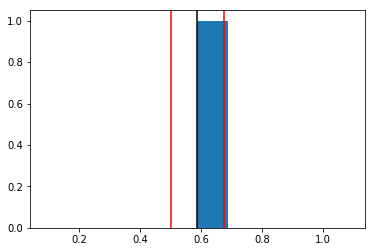

In [55]:
ax=plt.hist(mean)
plt.axvline(x=mean, color= 'k')
plt.axvline(x= CI[0], color='r')
plt.axvline(x=CI[1], color='r')



Null Hypothesis- democrats  neither supported nor rejected the bill

Alternative Hypothesis- democrate supported the bill

In [56]:
stats.ttest_1samp(handicapped, 0.4)
# reject the null hypothesis only 40% of the democrate in support of bill due to P<0.01

Ttest_1sampResult(statistic=4.253259640144092, pvalue=4.1319742864232485e-05)

due to pvalue(<0,01)lie within the confidence interval  i would reject the null hypothesis only 40% of the democrate in support of bill

In [57]:
stats.ttest_1samp(handicapped, 0.6)
# reject the null hypothesis only 40% of the democrate in support of bill

Ttest_1sampResult(statistic=-0.25446852547870513, pvalue=0.7995585588178784)

due to pvalue(>0.05 ) lie outside the range of confidence interval i would fail to reject the null hypothesis of 60% democrate supported the bill 

In [0]:
def confidence_interval(data, confidence=0.95):
  """
  Calculate a confidence interval around a sample mean for given data.
  Using t-distribution and two-tailed test, default 95% confidence. 
  
  Arguments:
    data - iterable (list or numpy array) of sample observations
    confidence - level of confidence for the interval
  
  Returns:
    tuple of (mean, lower bound, upper bound)
  """
  data = np.array(data)
  mean = np.mean(data)
  n = len(data)
  stderr = stats.sem(data)
  interval = stderr * stats.t.ppf((1 + confidence) / 2.0, n - 1)
  return (mean, mean - interval, mean + interval) 
  

##chi squared test 

In [59]:
df = pd.read_csv('https://raw.githubusercontent.com/ryanleeallred/datasets/master/adult.csv', na_values=" ?")
print(df.shape)
df.head()

(32561, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


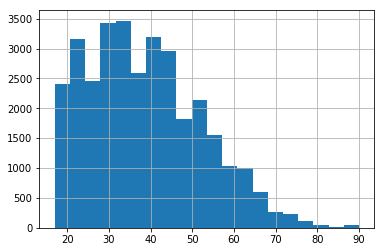

In [60]:
df['age'].hist(bins=20)

In [61]:
#convert into categorical variable
cut_points = [0, 19, 39, 59, 79, 99]
label_names = ['0-19','20-39','40-59','60-79','80+']
#df['age_categories']=pd.cut(df['age'],6)
df['age_categories'] = pd.cut(df['age'], cut_points, labels=label_names)
df.age_categories.value_counts()

20-39    16667
40-59    11593
60-79     2523
0-19      1657
80+        121
Name: age_categories, dtype: int64

In [62]:
df.race.value_counts()

 White                 27816
 Black                  3124
 Asian-Pac-Islander     1039
 Amer-Indian-Eskimo      311
 Other                   271
Name: race, dtype: int64

In [63]:
df=df.sort_values(by='age_categories')
contingency_table=pd.crosstab(df['race'],df['age_categories'], margins= True)
contingency_table

age_categories,0-19,20-39,40-59,60-79,80+,All
race,,,,,,
Amer-Indian-Eskimo,13,174,106,16,2,311
Asian-Pac-Islander,28,601,345,60,5,1039
Black,136,1689,1109,184,6,3124
Other,18,175,71,7,0,271
White,1462,14028,9962,2256,108,27816
All,1657,16667,11593,2523,121,32561


In [64]:
#Null two variables are independent
# expected value calculation
total= contingency_table.loc['All', 'All']
total

32561

In [65]:
row_sum=contingency_table.iloc[0:5, 5 ].values
col_sum=contingency_table.iloc[5, 0:5].values
print(row_sum)
print(col_sum)

[  311  1039  3124   271 27816]
[ 1657 16667 11593  2523   121]


In [66]:
expected=[]
for i in range(len(row_sum)):
  expected_row=[]
  for j in range(len(col_sum)):
    expected_value=row_sum[i]*col_sum[j]/total
    expected_row.append(expected_value)
  expected.append(expected_row) 
  
   
expected=np.array(expected)
print(expected.shape)
print(expected) 
    
    

(5, 5)
[[1.58265102e+01 1.59191579e+02 1.10728264e+02 2.40979393e+01
  1.15570775e+00]
 [5.28737754e+01 5.31832960e+02 3.69924972e+02 8.05072633e+01
  3.86103007e+00]
 [1.58977550e+02 1.59908197e+03 1.11226719e+03 2.42064187e+02
  1.16091029e+01]
 [1.37909462e+01 1.38716778e+02 9.64866865e+01 2.09985258e+01
  1.00706367e+00]
 [1.41553122e+03 1.42381767e+04 9.90359289e+03 2.15533208e+03
  1.03367096e+02]]


In [67]:
observed_table=pd.crosstab(df['race'], df['age_categories']).values
print(observed_table.shape)
observed_table

(5, 5)


array([[   13,   174,   106,    16,     2],
       [   28,   601,   345,    60,     5],
       [  136,  1689,  1109,   184,     6],
       [   18,   175,    71,     7,     0],
       [ 1462, 14028,  9962,  2256,   108]])

In [68]:
# chi squared test using numpy
chi_square=((observed_table-expected)**2/(expected)).sum()
chi_square

96.1114555049066

In [69]:
#Chi squared using scipy
chi_squared, p_value, dof, expected = stats.chi2_contingency(observed_table)
print(chi_squared, p_value, dof, expected)

96.1114555049066 1.8454982862885966e-13 16 [[1.58265102e+01 1.59191579e+02 1.10728264e+02 2.40979393e+01
  1.15570775e+00]
 [5.28737754e+01 5.31832960e+02 3.69924972e+02 8.05072633e+01
  3.86103007e+00]
 [1.58977550e+02 1.59908197e+03 1.11226719e+03 2.42064187e+02
  1.16091029e+01]
 [1.37909462e+01 1.38716778e+02 9.64866865e+01 2.09985258e+01
  1.00706367e+00]
 [1.41553122e+03 1.42381767e+04 9.90359289e+03 2.15533208e+03
  1.03367096e+02]]


Null Hypothesis- Age is independent of race
Due to p< 0.01 i would reject the Null hypothesis

##Stertch Goal

In [0]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [71]:
import pandas as pd

columns=['party','handicapped-infants','water-project',
                          'budget','physician-fee-freeze', 'el-salvador-aid',
                          'religious-groups','anti-satellite-ban',
                          'aid-to-contras','mx-missile','immigration',
                          'synfuels', 'education', 'right-to-sue','crime','duty-free',
                          'south-africa']
df=pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data', names= columns, na_values='?')
print(df.shape)
df.head()

(435, 17)


,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
0,republican,n,y,n,y,y,y,n,n,n,y,NaN,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,NaN
2,democrat,NaN,y,y,NaN,y,y,n,n,n,n,y,n,y,y,n,n
3,democrat,n,y,y,n,NaN,y,n,n,n,n,y,n,y,n,n,y
4,democrat,y,y,y,n,y,y,n,n,n,n,y,NaN,y,y,y,y


In [72]:
df=df.replace({'?':np.nan, 'y':1, 'n':0})
df=df.dropna()
df.head()

,party,handicapped-infants,water-project,budget,physician-fee-freeze,el-salvador-aid,religious-groups,anti-satellite-ban,aid-to-contras,mx-missile,immigration,synfuels,education,right-to-sue,crime,duty-free,south-africa
5,democrat,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
8,republican,0.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0
19,democrat,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
23,democrat,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
25,democrat,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0


In [0]:
#df = df.values
#df
#array([['democrat', 0.0, 1.0, ..., 1.0, 1.0, 1.0],
#       ['republican', 0.0, 1.0, ..., 1.0, 0.0, 1.0],
 #      ['democrat', 1.0, 1.0, ..., 0.0, 1.0, 1.0],
  #     ...,
   #    ['republican', 0.0, 0.0, ..., 1.0, 0.0, 1.0],
    #   ['republican', 0.0, 0.0, ..., 1.0, 0.0, 1.0],
     #  ['democrat', 0.0, 0.0, ..., 0.0, 0.0, 1.0]], dtype=object)
#df.T
#array([['democrat', 'republican', 'democrat', ..., 'republican',
#        'republican', 'democrat'],
 #      [0.0, 0.0, 1.0, ..., 0.0, 0.0, 0.0],
  #     [1.0, 1.0, 1.0, ..., 0.0, 0.0, 0.0],
   #    ...,
    #   [1.0, 1.0, 0.0, ..., 1.0, 1.0, 0.0],
     #  [1.0, 0.0, 1.0, ..., 0.0, 0.0, 0.0],
      # [1.0, 1.0, 1.0, ..., 1.0, 1.0, 1.0]], dtype=object)

In [0]:
def confidence_interval(data, confidence=0.5):
  """
  Calculate a confidence interval around a sample mean for given data.
  Using t-distribution and two-tailed test, default 95% confidence. 
  
  Arguments:
    data - iterab12le (list or numpy array) of sample observations
    confidence - level of confidence for the interval
  
  Returns:
    tuple of (mean, lower bound, upper bound)
  """
  data = np.array(data)
  mean = np.mean(data)
  n = len(data)
  stderr = stats.sem(data)
  interval = stderr * stats.t.ppf((1 + confidence) / 2.0, n - 1)
  return (mean, mean - interval, mean + interval)

In [0]:
def confidence_interval_dataframe(df):
  
  confidence_intervals = []
  
  # Turn dataframe into a numpy array
  # List values by column and not by row
  df = df.values.T
  
  # Remove nan values from columns
  cleaned_df = []
  for col in df:
    cleaned_col = col[~np.isnan(col)]
    
    # Calculate Confidence interval for each issue
    confidence_intervals.append(confidence_interval(cleaned_col))
    
  confidence_intervals = pd.DataFrame(confidence_intervals, columns=['mean', 'lower', 'upper'])  
    
  return confidence_intervals

In [76]:
only_votes = demo.drop('Party', axis='columns')

confidence_interval_df = confidence_interval_dataframe(only_votes)
confidence_interval_df.head()

,mean,lower,upper
0,0.588710,0.558695,0.618724
1,0.451613,0.421258,0.481968
2,0.854839,0.833352,0.876326
3,0.048387,0.035298,0.061476
4,0.201613,0.177141,0.226085


In [77]:
confidence_interval_df['margin_of_error'] = confidence_interval_df['upper'] - confidence_interval_df['mean']

print(confidence_interval_df.shape)
confidence_interval_df.head()

(16, 4)


,mean,lower,upper,margin_of_error
0,0.588710,0.558695,0.618724,0.030015
1,0.451613,0.421258,0.481968,0.030355
2,0.854839,0.833352,0.876326,0.021487
3,0.048387,0.035298,0.061476,0.013089
4,0.201613,0.177141,0.226085,0.024472


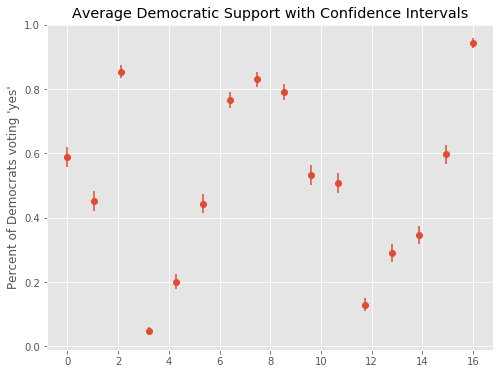

In [87]:
x = np.linspace(0, confidence_interval_df.shape[0], confidence_interval_df.shape[0])
y = confidence_interval_df['mean']
yerr = confidence_interval_df['margin_of_error']

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(8,6))
plt.errorbar(x, y, yerr, fmt='o',);

plt.title('Average Democratic Support with Confidence Intervals')
plt.ylabel("Percent of Democrats voting 'yes'");

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 16 Text xticklabel objects>)

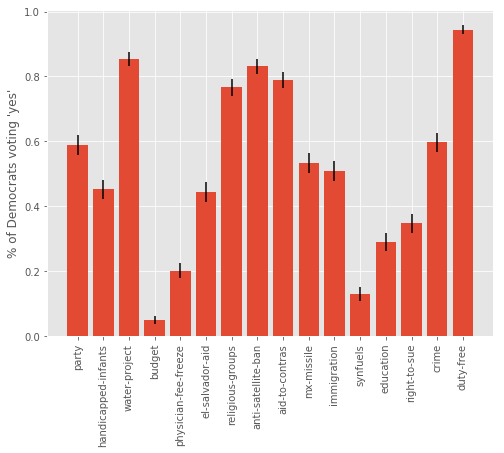

In [110]:
fig, ax = plt.subplots(figsize=(8,6))
means = confidence_interval_df['mean']
error = confidence_interval_df['margin_of_error']
x_pos = np.arange(confidence_interval_df.shape[0])
issues = ['party','handicapped-infants','water-project',
                          'budget','physician-fee-freeze', 'el-salvador-aid',
                          'religious-groups','anti-satellite-ban',
                          'aid-to-contras','mx-missile','immigration',
                          'synfuels', 'education', 'right-to-sue','crime','duty-free',
                          'south-africa']

# Matplotlib Named Colors: https://matplotlib.org/2.0.0/examples/color/named_colors.html
ax.bar(x, means, yerr=error)
ax.set_ylabel("% of Democrats voting 'yes'")
ax.set_xticks(x_pos);
ax.set_xticklabels(issues)
plt.xticks(rotation=90)
#ax.yaxis.grid(True)

#plt.show()

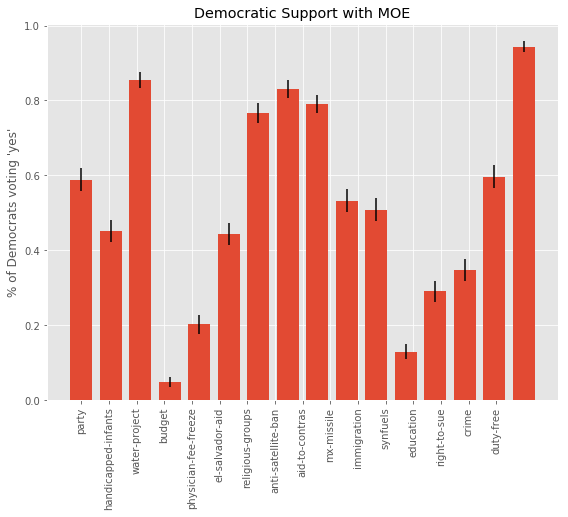

In [79]:
fig, ax = plt.subplots(figsize=(8,6))
means = confidence_interval_df['mean']
error = confidence_interval_df['margin_of_error']
x_pos = np.arange(confidence_interval_df.shape[0])
issues = ['party','handicapped-infants','water-project',
                          'budget','physician-fee-freeze', 'el-salvador-aid',
                          'religious-groups','anti-satellite-ban',
                          'aid-to-contras','mx-missile','immigration',
                          'synfuels', 'education', 'right-to-sue','crime','duty-free',
                          'south-africa']

# Matplotlib Named Colors: https://matplotlib.org/2.0.0/examples/color/named_colors.html
ax.bar(x, means, yerr=error)
ax.set_ylabel("% of Democrats voting 'yes'")
ax.set_xticks(x_pos)
ax.set_xticklabels(issues)
ax.set_title('Democratic Support with MOE', color='k')
ax.yaxis.grid(True)

# Save the figure and show
# Different style sheets: https://matplotlib.org/3.1.0/gallery/style_sheets/style_sheets_reference.html
plt.style.use('ggplot')
plt.tight_layout()
plt.xticks(rotation=90)
plt.savefig('bar_plot_with_error_bars.png')
plt.show()

In [80]:
# Plot Kernel Density Function for Immigration with Confidence Interval
from scipy.stats import t

immigration = demo['immigration'].dropna()
n = len(immigration)
mean = immigration.mean()
sample_std = immigration.std()
std_err = sample_std/n**.5
# std_err = sample_std/np.sqrt(n)

CI_immigration = t.interval(.95, n-1, loc=mean, scale=std_err)
print("95% Confidence Interval: ", CI_immigration)

95% Confidence Interval:  (0.4432039935587721, 0.6213121354734858)


In [81]:
confidence_interval(immigration)

(0.532258064516129, 0.5018230968713789, 0.5626930321608791)

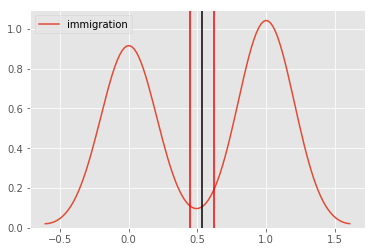

In [82]:
import seaborn as sns

sns.kdeplot(immigration)
plt.axvline(x=CI_immigration[0], color='red')
plt.axvline(x=CI_immigration[1], color='red')
plt.axvline(x=mean, color='k');

In [83]:
immigration = demo['immigration'].dropna()
n = len(immigration)
mean = immigration.mean()
sample_std = immigration.std()
std_err = sample_std/n**.5

print(n-1)
CI_immigration = t.interval(.95, n-1, loc=mean, scale=std_err)
print("95% Confidence Interval: ", CI_immigration)

123
95% Confidence Interval:  (0.4432039935587721, 0.6213121354734858)


Plotting a confidence interval on the density plot of our sample doesn't look that great because these two things are not as related to each other as we might think.
The confidence interval is related to the distribution of sample means if we were to run this experiment multiple times.
This is impossible to do with the congressional data unless we could relive the 80s over and over again.



import seaborn as sns

## Resources

- [Interactive visualize the Chi-Squared test](https://homepage.divms.uiowa.edu/~mbognar/applets/chisq.html)
- [Calculation of Chi-Squared test statistic](https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test)
- [Visualization of a confidence interval generated by R code](https://commons.wikimedia.org/wiki/File:Confidence-interval.svg)
- [Expected value of a squared standard normal](https://math.stackexchange.com/questions/264061/expected-value-calculation-for-squared-normal-distribution) (it's 1 - which is why the expected value of a Chi-Squared with $n$ degrees of freedom is $n$, as it's the sum of $n$ squared standard normals)